<a href="https://colab.research.google.com/github/jethin7911/Predictive-Maintaince-of-Sensors-in-UAVs/blob/main/file1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training shape: (268, 85)
Testing shape: (116, 85)
Removing constant columns with zero variance: ['field.power_supply_status', 'field.power_supply_health', 'field.power_supply_technology', 'field.present', 'field.orientation.x', 'field.orientation.y', 'field.orientation.z', 'field.orientation.w', 'field.orientation_covariance0', 'field.orientation_covariance1', 'field.orientation_covariance2', 'field.orientation_covariance3', 'field.orientation_covariance4', 'field.orientation_covariance5', 'field.orientation_covariance6', 'field.orientation_covariance7', 'field.orientation_covariance8', 'field.angular_velocity_covariance1', 'field.angular_velocity_covariance2', 'field.angular_velocity_covariance3', 'field.angular_velocity_covariance5', 'field.angular_velocity_covariance6', 'field.angular_velocity_covariance7', 'field.linear_acceleration_covariance1', 'field.linear_acceleration_covariance2', 'field.linear_acceleration_covariance3', 'field.linear_acceleration_covariance5', 'field.linear

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model training complete.

Testing results sample:
     field.header.seq         %time  field.header.stamp  \
268               320  1.574070e+18        1.574070e+18   
250               302  1.574070e+18        1.574070e+18   
355                23  1.574070e+18        1.574070e+18   
332                 0  1.574070e+18        1.574070e+18   
56                108  1.574070e+18        1.574070e+18   

     field.header.frame_id  field.voltage  field.current  field.charge  \
268                    NaN      16.399000      -0.000000           NaN   
250                    NaN      16.348000      -0.000000           NaN   
355                    NaN      16.342122      -1.032293           NaN   
332                    NaN      16.342122      -1.032293           NaN   
56                     NaN      16.351999      -0.000000           NaN   

     field.capacity  field.design_capacity  field.percentage  ...  \
268             NaN                    NaN              0.99  ...   
250         

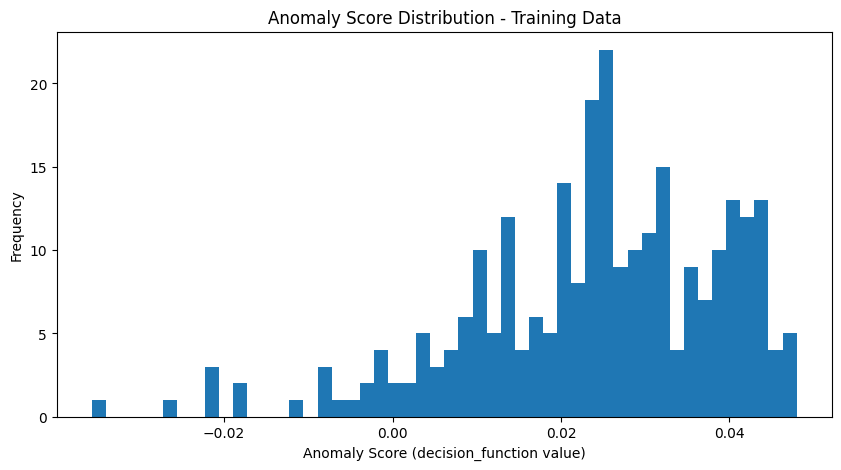

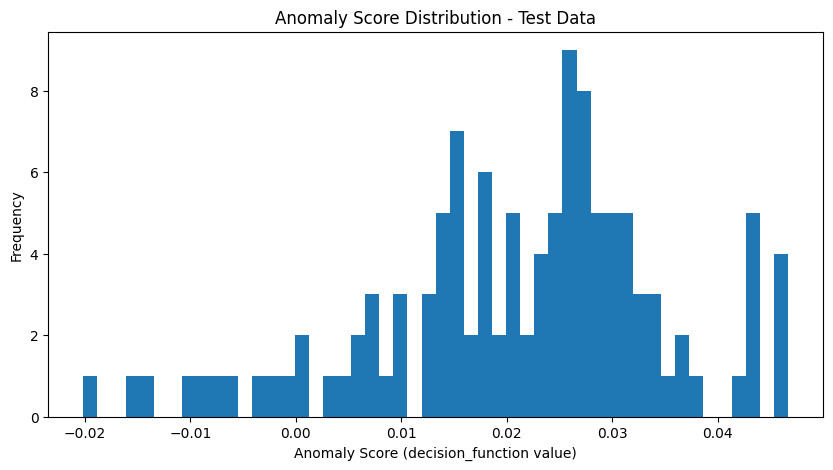


Training Data:
Total points: 268
Anomalies detected: 20
Percentage of anomalies: 7.46%

Testing Data:
Total points: 116
Anomalies detected: 10
Percentage of anomalies: 8.62%


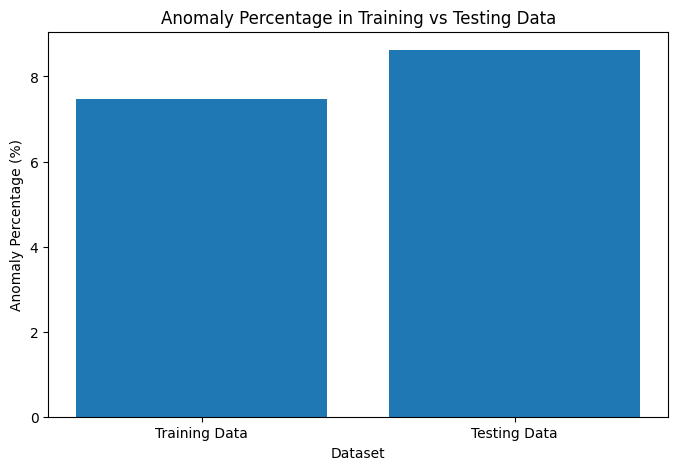

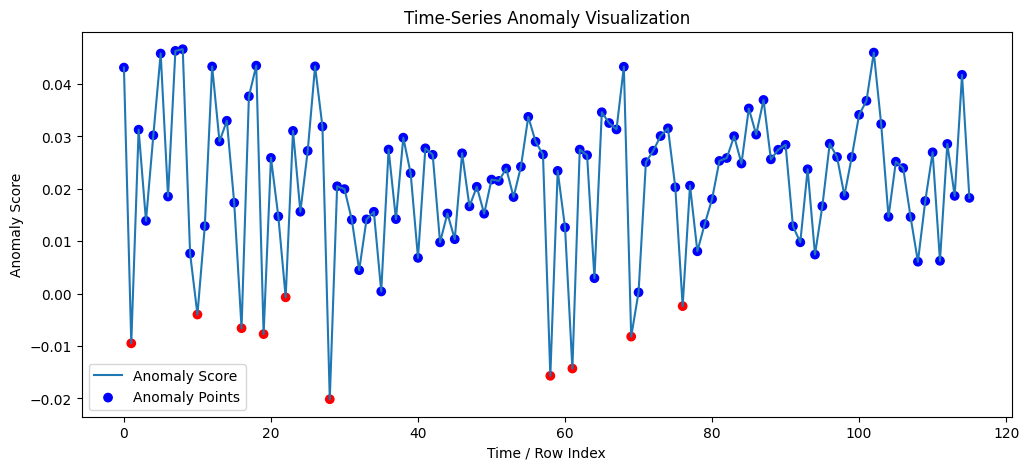

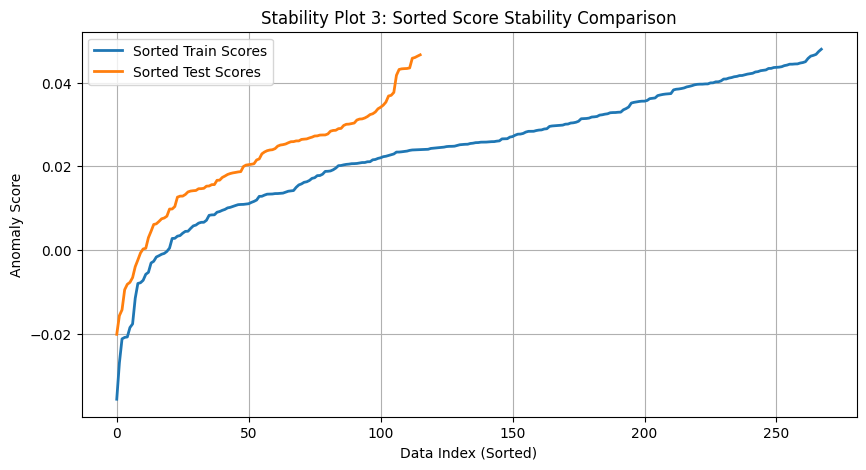

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. Load dataset
# ----------------------------
data = pd.read_csv("new_data_set.csv")

# Select numeric columns only
numeric_data = data.select_dtypes(include=[np.number])


# ----------------------------
# 3. Train-test split (70/30)
# ----------------------------
X_train, X_test = train_test_split(
    numeric_data,
    test_size=0.30,
    shuffle=True,
    random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

# ----------------------------
# 2. Normalize the data
# ----------------------------

# Store means from X_train for all columns to use for imputation
# This handles cases where X_train might not have NaN in a column, but X_test does.
imputation_means = X_train.mean()

# Impute NaN values in X_train and X_test using means calculated from X_train
X_train = X_train.fillna(imputation_means)
X_test = X_test.fillna(imputation_means)


# Identify and remove constant columns (zero variance) from X_train
# These columns cause RuntimeWarning in StandardScaler
constant_columns = [col for col in X_train.columns if X_train[col].std() == 0]

if constant_columns:
    print(f"Removing constant columns with zero variance: {constant_columns}")
    X_train = X_train.drop(columns=constant_columns)
    X_test = X_test.drop(columns=constant_columns)
else:
    print("No constant columns found.")

scaler = StandardScaler()

# Fit scaler ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using SAME scaler
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 4. Train Isolation Forest on training data
# ----------------------------
model = IsolationForest(
    n_estimators=200,
    contamination='auto',
    random_state=42
)

model.fit(X_train_scaled)

print("Model training complete.")

# ----------------------------
# 5. Predict anomalies on TRAINING data
# ----------------------------
train_predictions = model.predict(X_train_scaled)

# ----------------------------
# 6. Predict anomalies on TESTING data
# ----------------------------
test_predictions = model.predict(X_test_scaled)

# Add predictions to test set for inspection
X_test_results = X_test.copy() # X_test here refers to the cleaned version
X_test_results["fault_prediction"] = test_predictions   # 1=normal, -1=anomaly

print("\nTesting results sample:")
print(X_test_results.head())

# Save output
X_test_results.to_csv("test_results_with_predictions.csv", index=False)
print("\nSaved results to test_results_with_predictions.csv")


# ---------------------------------------------------
# 7. Get anomaly scores for train and test data
# ---------------------------------------------------
train_scores = model.decision_function(X_train_scaled)  # Higher = normal, Lower = anomaly
test_scores = model.decision_function(X_test_scaled)

# ---------------------------------------------------
# 8. Plot anomaly score distribution (Train Data)
# ---------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(train_scores, bins=50)
plt.title("Anomaly Score Distribution - Training Data")
plt.xlabel("Anomaly Score (decision_function value)")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------------
# 9. Plot anomaly score distribution (Test Data)
# ---------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(test_scores, bins=50)
plt.title("Anomaly Score Distribution - Test Data")
plt.xlabel("Anomaly Score (decision_function value)")
plt.ylabel("Frequency")
plt.show()


X_test_results["anomaly_score"] = test_scores
X_test_results.to_csv("test_results_with_predictions.csv", index=False)


# ----------------------------------------------
# 10. Percentage of anomalies in TRAINING data
# ----------------------------------------------
train_anomalies = np.sum(train_predictions == -1)
train_total = len(train_predictions)
train_anomaly_percentage = (train_anomalies / train_total) * 100

print(f"\nTraining Data:")
print(f"Total points: {train_total}")
print(f"Anomalies detected: {train_anomalies}")
print(f"Percentage of anomalies: {train_anomaly_percentage:.2f}%")

# ----------------------------------------------
# 11. Percentage of anomalies in TESTING data
# ----------------------------------------------
test_anomalies = np.sum(test_predictions == -1)
test_total = len(test_predictions)
test_anomaly_percentage = (test_anomalies / test_total) * 100

print(f"\nTesting Data:")
print(f"Total points: {test_total}")
print(f"Anomalies detected: {test_anomalies}")
print(f"Percentage of anomalies: {test_anomaly_percentage:.2f}%")


# ----------------------------------------------
# Use the anomaly percentages you calculated
# ----------------------------------------------
labels = ['Training Data', 'Testing Data']
values = [train_anomaly_percentage, test_anomaly_percentage]

# ----------------------------------------------
#  Bar Chart for Anomaly Percentages
# ----------------------------------------------
plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel('Dataset')
plt.ylabel('Anomaly Percentage (%)')
plt.title('Anomaly Percentage in Training vs Testing Data')
plt.show()


# Convert scaled arrays back to DataFrame for plotting
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_df["prediction"] = train_predictions


plt.figure(figsize=(12,5))

plt.plot(test_scores, label="Anomaly Score")
plt.scatter(range(len(test_predictions)), test_scores,
            c=np.where(test_predictions == -1, 'red', 'blue'),
            label="Anomaly Points")

plt.xlabel("Time / Row Index")
plt.ylabel("Anomaly Score")
plt.title("Time-Series Anomaly Visualization")
plt.legend()
plt.show()

import matplotlib.pyplot as plt

# Convert scaled test data back to DataFrame for plotting
test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
test_df["prediction"] = test_predictions   # 1 = normal, -1 = anomaly


train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

plt.figure(figsize=(10,5))
plt.plot(sorted(train_scores), label="Sorted Train Scores", linewidth=2)
plt.plot(sorted(test_scores), label="Sorted Test Scores", linewidth=2)
plt.title("Stability Plot 3: Sorted Score Stability Comparison")
plt.xlabel("Data Index (Sorted)")
plt.ylabel("Anomaly Score")
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
import os
print(os.listdir('.'))

from google.colab import files
files.download('test_results_with_predictions.csv')

['.config', 'test_results_with_predictions.csv', 'new_data_set.csv', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>